In [1]:
import graphviz as gr
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from tqdm import tqdm
random.seed(10)

In [2]:
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

In [3]:
### Q1 Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.


In [4]:
##simulate a DGP


In [5]:
np.random.seed(22)
n = 1000
T = np.random.binomial(1, 0.5, n)
X = np.random.normal(20,5,n)
Y = np.random.normal(1 + 1*T + 1*X, 5).astype(int)
data1 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data1.to_csv("data1.csv", index=False)

In [6]:
##Illustrate DGP with a DAG

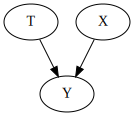

In [7]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g

In [8]:
##Running Monte Carlo experiment

In [9]:
##case a : You do not control for any covariates

In [10]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(20,5,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(a + b*T + 1*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        theta0 = b
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            [a_hat,b_hat], se = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [bias,RMSE,treatment_effect]

In [11]:
# N=100
mcSim_100 = MC_Simulator_a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,0.065891,-0.019681
RMSE,1.408059,0.453298
size,0.053000,0.055000


In [12]:
##case b: controlling for all the covariates that affect the outcome


In [13]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(20,5,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(a + b*T + c*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = b
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [bias,RMSE,treatment_effect]

In [14]:
# N=100
mcSim_100 = MC_Simulator_b(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
##listing the results as a form
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,0.017994,0.010872
RMSE,1.048010,0.318425
size,0.840000,0.872000


In [15]:
##example of real-life situation that might be consistent with the DGP

In [16]:
"""T: involving in a job-traning program of government
   X: education background
   Y: hourly wage"""
 

'T: involving in a job-traning program of government\n   X: education background\n   Y: hourly wage'

In [17]:
##Q2 Simulate a DGP with a confounder (common cause)

In [18]:
np.random.seed(22)
n = 1000
# generate confounder
X = np.random.normal(1,5,n)
# generate treatment
T = np.random.binomial(1, 1/(1+X**2), n)
# generate outcome
Y = np.random.normal(1 + 1*T + 1*X, 5).astype(int)
data2 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data2.to_csv("data2.csv", index=False)

In [19]:
##Illustrate DGP with a DAG

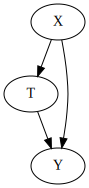

In [27]:
g = gr.Digraph()
g.edge("X", "T")
g.edge("T", "Y")
g.edge("X", "Y")
g

In [21]:
##Monte Carlo experiment


In [22]:
##case a : You fail to control for the confounder 


In [23]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(1,5,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(a + b*T + 1*X, 5).astype(int)
        
        return (Y,T)  

    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        theta0 = b
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            [a_hat,b_hat], se = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [bias,RMSE,treatment_effect]

In [24]:
# N=100
mcSim_100 = MC_Simulator_a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
#listing the results as a form
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-1.037859,-1.129211
RMSE,1.710583,1.204182
size,0.047000,0.607000


In [25]:
#case b : controlling for the confounder

In [26]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(1,5,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(a + b*T + c*X, 5).astype(int)
        
        return (Y,T,X) 
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = b
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, size = self.run_mc_simulation(a,b,c,n,sigma)
        return [bias,RMSE,size]

In [28]:
# N=100
mcSim_100 = MC_Simulator_b(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
#listing the results as a form
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-0.105413,-0.095253
RMSE,1.185434,0.381538
size,0.876000,0.877000


In [29]:
#example of real-life situation that might be consistent with the DGP

In [30]:
"""X : Self-motivation of a person
   T : involving in the traning program of government
   Y : hourly wage  """

'X : Self-motivation of a person\n   T : involving in the traning program of government\n   Y : hourly wage  '

In [31]:
##Q3 Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

In [32]:
##simulate a DGP

In [33]:
np.random.seed(22)
n = 1000
# generate treatment
T = np.random.binomial(1, 0.5, n)
# generate outcome
Y = np.random.normal(1 + 1*T, 5).astype(int)
# generate covariate
X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)

data3 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data3.to_csv("data3.csv", index=False)

In [34]:
##Illustrate DGP with a DAG


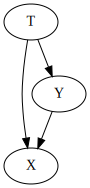

In [35]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("Y", "X")
g

In [36]:
##Monte Carlo experiment


In [37]:
##case a : You control for the variable in between the path from cause to effect


In [38]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 1*T, 5).astype(int)
        X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = 1
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [bias,RMSE,treatment_effect]

In [39]:
# N=100
mcSim_100 = MC_Simulator_a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
#listing the results as a form
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-0.030119,-0.074406
RMSE,0.909836,0.297165
size,0.822000,0.850000


In [40]:
## case b: You do not control for the variable in between the path from cause to effect

In [41]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 1*T, 5).astype(int)
        X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)
        
        return (Y,T)  
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        theta0 = 1
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            [a_hat,b_hat], se = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [bias,RMSE,treatment_effect]

In [42]:
# N=100
mcSim_100 = MC_Simulator_b(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
#listing the results as a form
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,-0.059011,-0.062965
RMSE,0.965511,0.287686
size,0.066000,0.052000


In [43]:
##example of real-life situation that might be consistent with the DGP


In [44]:
"""T : Education level  Y : wage level  X : income from the investment """

'T : Education level  Y : wage level  X : income from the investment '

In [45]:
##Q4  Simulate a DGP where the outcome variable is overrepresented at 0.

In [46]:
#simulating the DGP

In [47]:
np.random.seed(24)
n = 1000

T = np.random.binomial(1, 0.5, n)

X = np.random.gamma(1, 1, n)

P = np.random.normal(5 + 0.3+X, 500)
P = ((P > 800) & (P == 1)).astype(int)

Y = (np.random.normal(-2+1*P, 10).astype(int))+ 0.5*X
for i in range(len(Y)):
    if Y[i]<0:
        Y[i]=0

data4 = pd.DataFrame(dict(Y=Y,
                         P=P,
                         T=T,
                         X=X))

data4.to_csv("data4.csv", index=False)

In [48]:
#Illustrate your DGP with a DAG

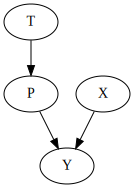

In [49]:
g = gr.Digraph()

g.edge("T", "P"), g.edge("P", "Y")
g.edge("X", "Y")

g

In [50]:
##Monte Carlo experiment

In [51]:
#case a: You estimate the treatment effect parameter using the Conditional-on-Positives (COP) framework

In [52]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        X = np.random.gamma(1, 1, n)
        P = np.random.normal(5 + 0.3+X, 500)
        P = ((P > 800) & (T == 1)).astype(int)
        Y = (np.random.normal(-2+1*P, 10).astype(int))+ 0.5*X
        for i in range(len(Y)):
            if Y[i]<0:
                Y[i]=0
        df = pd.DataFrame(dict(Y=Y,P=P,T=T,X=X))
        for i in range(len(df)):
            p = np.random.binomial(1,0.5)
            if df['Y'].loc[i]==0:
                if p==1:
                    df.drop([i],inplace = True)
        Y = np.array(df['Y'])
        T = np.array(df['T'])
        X = np.array(df['X'])
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = -2
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, size = self.run_mc_simulation(a,b,c,n,sigma)
        return [bias,RMSE,size]

In [53]:
# N=100
mcSim_100 = MC_Simulator_a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
#listing the results as a form
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,2.022121,2.019970
RMSE,2.411781,2.065526
size,0.709000,1.000000


In [54]:
##case b You estimate the treatment effect using the conventional method of comparing the outcomes of treated and untreated individuals.

In [55]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        X = np.random.gamma(1, 1, n)
        P = np.random.normal(5 + 0.3+X, 500)
        P = ((P > 800) & (T == 1)).astype(int)
        Y = (np.random.normal(-2+1*P, 10).astype(int))+ 0.5*X
        for i in range(len(Y)):
            if Y[i]<0:
                Y[i]=0
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
                
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return [res.params,res.bse[1]]
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        theta0 = -2
        thetahat = []
        se_thetahat = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            [a_hat,b_hat,c_hat], se = self.estimate_ols_params(Y,T,X)
            thetahat = thetahat + [b_hat]
            se_thetahat = se_thetahat + [se]
        res = fn_bias_rmse_size(theta0,np.array(thetahat),np.array(se_thetahat),cval = 1.96)
        bias = res[0]
        RMSE = res[1]
        size = res[2]
        return bias, RMSE, size

In [56]:
# N=100
mcSim_100 = MC_Simulator_a(1000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(1000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
#listing the results
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','size']]
res

,N=100,N=1000
bias,2.068167,1.996417
RMSE,2.472362,2.041163
size,0.712000,1.000000


In [57]:
##real-life example

In [58]:
""" T:Advertise or not.  Y:Amount of consumption.  P:consumption possibility.  X:income."""

' T:Advertise or not.  Y:Amount of consumption.  P:consumption possibility.  X:income.'